## Basic Text Classification with Naive Bayes

In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on Lab 10 of Harvard's CS109 class. Please free to go to the original lab for additional exercises and solutions.

In [29]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# setup pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# setup seaborn
sns.set_style('whitegrid')
sns.set_context('poster')

### Table of Contents
Rotten Tomatoes Dataset
    * Explore
* The Vector Space Model and a Search Engine
    * In Code
* Naive Bayes
    * Multinomial Naive Bayes and Other Likelihood Functions
    * Picking Hyperparameters for Naive Bayes and Text Maintenance
* Interpretation

### Rotten Tomatoes Dataset

In [30]:
critics = pd.read_csv('./datasets/critics.csv')
# let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [31]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size

print("Number of reviews: {:d}".format(n_reviews))
print("Number of criticss: {:d}".format(n_critics))
print("Number of movies: {:d}".format(n_movies))

Number of reviews: 15561
Number of criticss: 623
Number of movies: 1921


([<matplotlib.axis.YTick at 0x1f188590b08>,
 <a list of 6 Text yticklabel objects>)

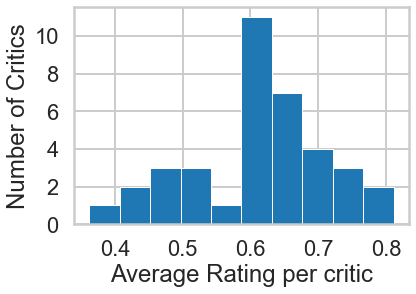

In [32]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count() # number of reviews by each critic
means = grp.fresh.mean() # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel('Average Rating per critic')
plt.ylabel('Number of Critics')
plt.yticks([0, 2, 4, 6, 8, 10])

E## xercise Set I

**Exercise:** Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?

The histogram above show that for critics that make more than 100 movie ratings, the average rating per critic is in between 0.4~0.8. Most of critics give average rating from 0.6 to 0.7, and few critics give average rating as low as 0.4, and few critics rated movie 0.55 or so averagely. The distribution looks bimodal, and could be related to some specific movies.

### The Vector Space Model and a Search Engine


All the diagrams here are snipped from Introduction to Information Retrieval by Manning et. al. which is a great resource on text processing. For additional information on text mining and natural language processing, see Foundations of Statistical Natural Language Processing by Manning and Schutze.

Also check out Python packages nltk, spaCy, pattern, and their associated resources. Also see word2vec.

### In Code

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

Original text is
Hop on pop
Hop off pop
Hop Hop hop


In [34]:
vectorizer = CountVectorizer(min_df=0)

# call 'fit' to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to convert back to a 
# 'normal' numpy array
x = x.toarray()

print("Transformed text vector is \n{}".format(x))

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]


In [35]:
# 'get_feature_names' tracks which is associated with each column of the transformed x
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Words for each feature:
['hop', 'off', 'on', 'pop']


In [36]:
def make_xy(critics, vectorizer=None):
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc() # some version of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X,y
X, y = make_xy(critics)

### Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$
where $c$ represents a class or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. We are computing the probability that a document (or whatever we are classifying) belongs to category c given the features in the document. $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$
$P(c)$ is called the prior and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the likelihood and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are conditionally independent given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear within that class. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$
Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$
where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For floating point underflow we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$
There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$
where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$
where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use Gaussian Naive Bayes. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

## Exercise Set II
Exercise: Implement a simple Naive Bayes classifier:

1. split the data set into a training and test set
2. Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
3. train the classifier over the training set and test on the test set
4. print the accuracy scores for both the training and the test sets
What do you notice? Is this a good classifier? If not, why not?

In [37]:
# your turn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

from sklearn.naive_bayes import MultinomialNB
m = MultinomialNB()
m.fit(X_train, y_train)
y_pred = m.predict(X_test)
accuracy_test = m.score(X_test, y_test)
accuracy_train = m.score(X_train, y_train)
print('The accuracy for train and test are {:3f} and {:3f} respectively.'.format(accuracy_train, accuracy_test))

The accuracy for train and test are 0.924991 and 0.776398 respectively.


### Picking Hyperparameters for Naive Bayes and Text Maintenance
We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for min_df for the CountVectorizer. min_df can be either an integer or a float/decimal. If it is an integer, min_df represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum percentage of documents a word must appear in to be included in the vocabulary. From the documentation:

**min_df:** When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

### Exercise Set III
Exercise: Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.

Exercise: Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?

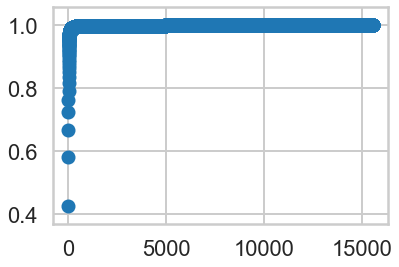

In [38]:
# your turn
new = np.where(X.toarray()>=1, 1, 0) # 1 represents that the words appears in the review (no matter how many times)
data1 = np.sort(np.sum(new, axis=0))
s = pd.Series(data1).value_counts()
s = s.iloc[np.lexsort([s.values, s.index])]
new_index = np.arange(1, X.shape[0])
s = s.reindex(new_index, fill_value=0)/X.shape[1]
plt.scatter(s.index, np.cumsum(s.values))
plt.show()

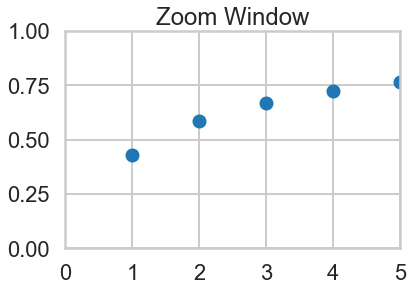

In [39]:
plt.scatter(s.index, np.cumsum(s.values))
plt.xlim(0, 5)
plt.ylim(0, 1.0)
plt.title('Zoom Window')
plt.show()

The point at which the curve begins climbing steeply is 2(df_min). df_max could be 20.

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function cv_score performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold.

In [40]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in scorefunc. The higher the log-likelihood, the better. Indeed, what we do in cv_score above is to implement the cross-validation part of GridSearchCV.

The custom scoring function scorefunc allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using roc_auc, precision, recall, or F1-score as the scoring function.

In [41]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [42]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

### Exercise Set IV
Exercise: What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?

Exercise: Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?

Exercise: Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.

1. log_likelihood gives the probability of correct prediction, namely, predicting rotten as 0 and predicting fresh as 1. By doing cross validation we are trying to make sure that our model would be generalizable to data sets and would not be largely affected by how train/test is split.
2. The terms that do not exist in training data would have too much of probability if we choose a value of alpha that is too high.

In [43]:
from sklearn.naive_bayes import MultinomialNB

# the grid of parameters to search over
alphas = [0.1, 1, 5, 10, 50]
best_min_df = 2 # Your turn: put your value of min_df here

# Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf

score = []
for alpha in alphas:
    vectorizer = CountVectorizer(min_df=best_min_df)
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
    m1 = MultinomialNB(alpha=alpha)
    score.append(cv_score(m1, Xtrainthis, ytrainthis, log_likelihood))

maxscore = np.max(score)
best_alpha = alphas[score.index(maxscore)]

In [44]:
print("alpha: {}".format(best_alpha))

alpha: 1


### Exercise Set V: Working with the Best Parameters
Exercise: Using the best value of `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?

In [68]:
vectorizer = CountVectorizer(min_df=best_min_df)
X,y = make_xy(critics, vectorizer)
xtrain = X[mask]
ytrain = y[mask]
xtest = X[~mask]
ytest = y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

# your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print('Accuracy on training data: {:2f}'.format(training_accuracy))
print('Accuracy on test data: {:2f}'.format(test_accuracy))

Accuracy on training data: 0.932962
Accuracy on test data: 0.746970


In [69]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[2457 1793]
 [ 963 5679]]


The classifier is any better. Original classifier with min_df=0 and default alpha=1 has training accuracy of 0.924 and testing accuracy of 0.765. The training accuracy was improved when changed min_df to 1, but testing accuracy was lowered slightly.

### Interpretation

#### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words).

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [70]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
# print(x)

In [71]:
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
            succeeds 0.96
            greatest 0.95
           excellent 0.95
            realized 0.94
            powerful 0.94
             delight 0.94
               fable 0.93
              superb 0.93
             creates 0.93
             stylish 0.93
Bad words	     P(fresh | word)
            plodding 0.12
              stinks 0.12
     disappointingly 0.12
             failure 0.12
                lame 0.11
              except 0.10
       unfortunately 0.09
          uninspired 0.09
           pointless 0.09
               bland 0.08


### Exercise Set VI
Exercise: Why does this method work? What does the probability for each row in the identity matrix represent

Probability matrix from classifier is of dimension (N,2). The first index refers to the probability that the data belong to class 0, and the second refers to the probability that the data belong to class 1. ?????

The above exercise is an example of feature selection. There are many other feature selection methods. A list of feature selection methods available in sklearn is here. The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ method.

### Prediction Errors

We can see mis-predictions as well.

In [74]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')

for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")
    
print("Mis-predicted Fresh quotes")
print('--------------------------')

for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")


Mis-predicted Rotten quotes
---------------------------
If it's to be experienced at all, Return to Paradise is best seen as a lively piece of pulp, not a profound exploration of the vagaries of the human soul.

All of this would work better if Robinson built up the reality of the town more, made the citizens a more palpable presence, as Frank Capra did in Hollywood's greatest fable-fantasy, It's a Wonderful Life.

While Last Days succeeds as a nature documentary, Van Sant fails to penetrate human nature. The result is a portrait without a face.

Benefits from a lively lead performance by the miscast Denzel Washington but doesn't come within light years of the book, one of the greatest American autobiographies.

What if this lesser-known chapter of German resistance had been more deeply captured? What if the moral conflicts running through this movie about love of country and revolt said more about Germany, war and, yes, genocide?

Mis-predicted Fresh quotes
--------------------------


### Exercise Set VII: Predicting the Freshness for a New Review

Exercise:
Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
Is the result what you'd expect? Why (not)?

In [75]:
# your turn

t = vectorizer.transform(['This movies is not remarkable, touching, or superb in any way'])
pred = m1.predict(t)

print('Not right result' if (pred == 1) else 'Correct')

Not right result


Not the results I expected. Could it be that the model think not only flipped the meaning of remarkable but there are 2 strong positive words (superb and touching) in the sentence.

### Aside: TF-IDF Weighting for Term Importance
TF-IDF stands for

Term-Frequency X Inverse Document Frequency.

In the standard CountVectorizer model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus. There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in scikit-learn differs from that of most textbooks:

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$
where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [76]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf = tfidfvectorizer.fit_transform(critics.quote)